<a href="https://colab.research.google.com/github/rounak393/imageprocessing/blob/main/Midas_classificiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:08<00:00, 170MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Saving input.jpg to input.jpg


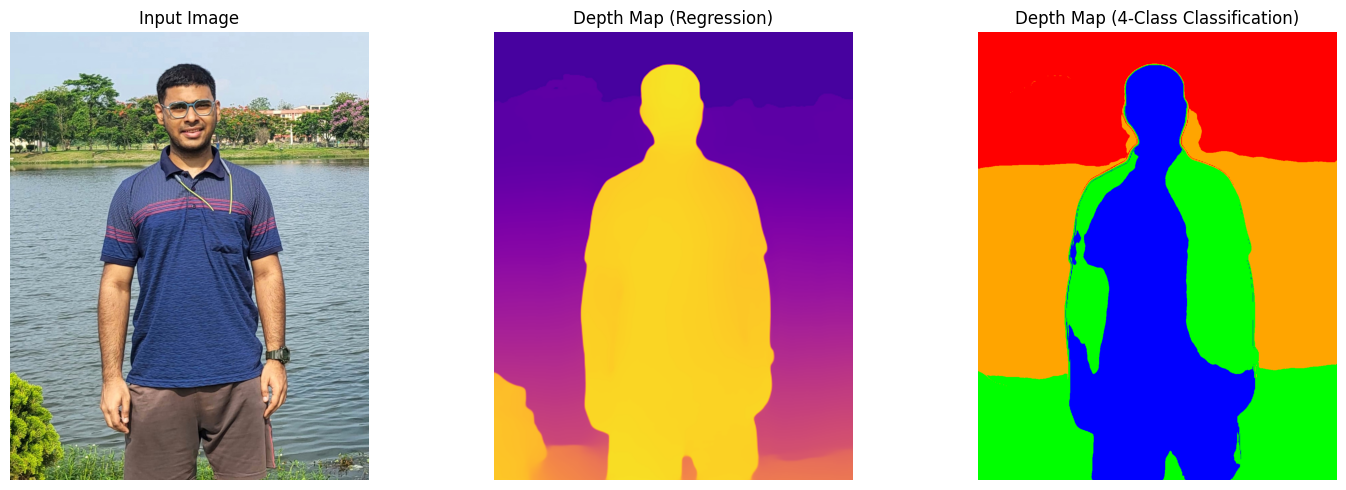

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import files
import os

# Load MiDaS model and transforms
model_type = "DPT_Large"  # You can switch to "DPT_Hybrid" or "MiDaS_small" for speed
midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device).eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
transform = midas_transforms.dpt_transform if "DPT" in model_type else midas_transforms.small_transform

# Upload an image
uploaded = files.upload()
input_image_path = list(uploaded.keys())[0]
img = Image.open(input_image_path).convert("RGB")
img_np = np.array(img)

# Transform the image
input_tensor = transform(img_np).to(device)

# Predict depth
with torch.no_grad():
    prediction = midas(input_tensor)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.size[::-1],  # (width, height)
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# Convert to numpy and normalize
depth = prediction.cpu().numpy()
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())

# Save and show regression (colored depth) image
depth_colored = (plt.cm.plasma(depth_normalized)[:, :, :3] * 255).astype(np.uint8)
depth_image = Image.fromarray(depth_colored)
depth_image.save("depth_map_regression.png")

# Bin into 4 categories: very near, near, far, very far
# Option 1: Use quantile-based bins (for equal distribution)
bins = np.quantile(depth_normalized, [0, 0.25, 0.5, 0.75, 1.0])
depth_classes = np.digitize(depth_normalized, bins[1:-1])

# Map each class to a distinct color
class_colors = np.array([
    [255, 0, 0],     # Very Near - Red
    [255, 165, 0],   # Near - Orange
    [0, 255, 0],     # Far - Green
    [0, 0, 255]      # Very Far - Blue
], dtype=np.uint8)

depth_class_colored = class_colors[depth_classes]
depth_class_image = Image.fromarray(depth_class_colored)
depth_class_image.save("depth_map_classified.png")

# ===== DISPLAY IMAGES =====
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Depth Map (Regression)")
plt.imshow(depth_colored)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Depth Map (4-Class Classification)")
plt.imshow(depth_class_colored)
plt.axis("off")

plt.tight_layout()
plt.show()